In [ ]:
# Enable inline plotting (for Jupyter Notebook only)
# Note: Use this only if running in Jupyter Notebook
%matplotlib inline

# Suppress warnings (for cleaner report)
import warnings
warnings.filterwarnings("ignore")

# Core libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt

# Financial data and statistical libraries
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Machine learning and data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# PyTS for Gramian Angular Field transformation
from pyts.image import GramianAngularField

# Print confirmation of imports
print("All packages are installed and imported successfully!")


2024-11-19 05:28:11.150519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


All packages are installed and imported successfully!


## **Step 1: Data Gathering and Analysis**

### **1. Data Gathering**

We'll use the daily closing prices of Bitcoin (BTC). We'll obtain the data from Yahoo Finance using the `yfinance` library.

[*********************100%***********************]  1 of 1 completed


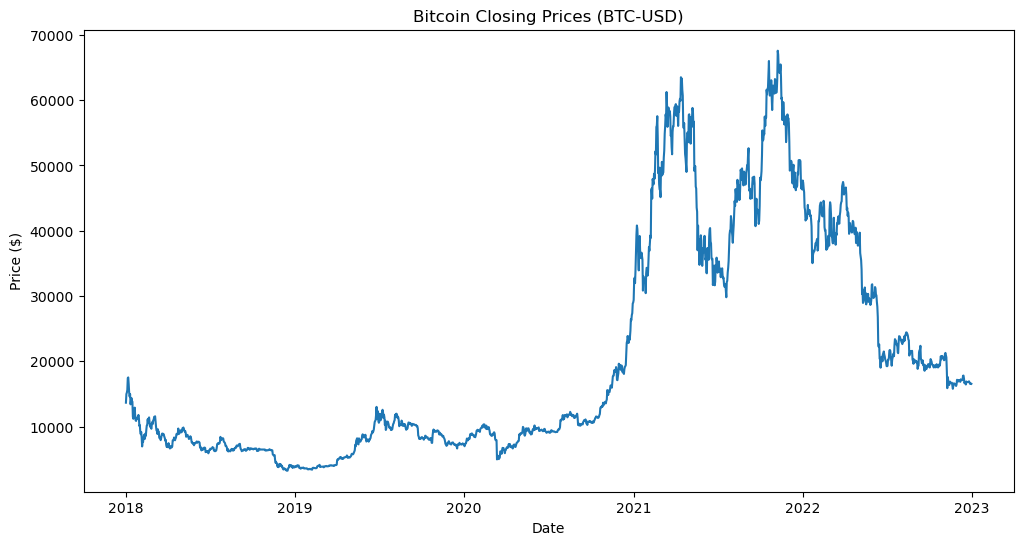

In [ ]:
# --- Data Gathering and Initial Exploration ---

# Download Bitcoin closing prices using Yahoo Finance
data = yf.download('BTC-USD', start='2018-01-01', end='2023-01-01')
prices = data['Close']
prices = prices[-2000:]  # Limit to the last 2,000 observations

# Plot the raw Bitcoin closing prices
plt.figure(figsize=(12, 6))
plt.plot(prices)
plt.title('Bitcoin Closing Prices (BTC-USD)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()


### **2. Characterization of the Time Series**

#### **Summary Statistics:**

In [ ]:
# Display summary statistics of the closing prices
print('Summary Statistics:')
print(prices.describe())


Summary Statistics:
count     1826.000000
mean     20338.668578
std      16986.017527
min       3236.761719
25%       7682.069092
50%      10960.592285
75%      33740.259766
max      67566.828125
Name: Close, dtype: float64


#### **Distribution Plot:**

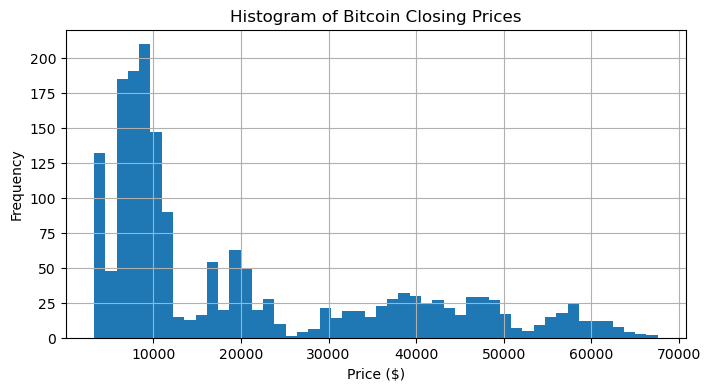

In [ ]:
# Plot histogram of Bitcoin closing prices
plt.figure(figsize=(8, 4))
prices.hist(bins=50)
plt.title('Histogram of Bitcoin Closing Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()


#### **Stationarity Test (ADF Test):**

In [ ]:
# --- Stationarity Check Using Augmented Dickey-Fuller (ADF) Test ---
adf_result = adfuller(prices)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')


ADF Statistic: -1.3680901469283677
p-value: 0.5974749358209461


### **3. Transformed Time Series Analysis**

We'll take the first difference of the log-transformed prices to achieve stationarity.

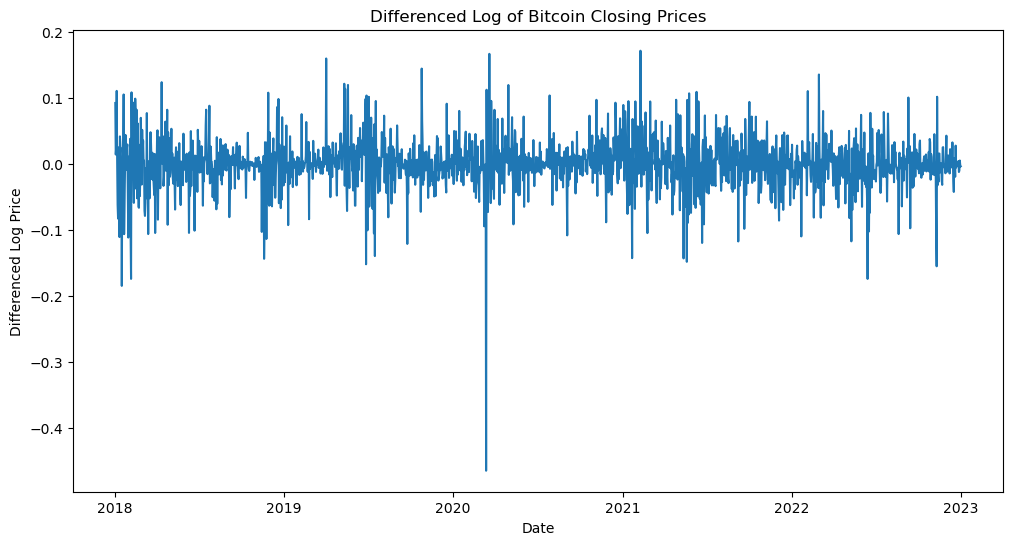

In [ ]:
# Log transformation to stabilize variance
log_prices = np.log(prices)

# Differencing to achieve stationarity
diff_log_prices = log_prices.diff().dropna()

# Plot the differenced log series
plt.figure(figsize=(12, 6))
plt.plot(diff_log_prices)
plt.title('Differenced Log of Bitcoin Closing Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Log Price')
plt.show()


#### **ADF Test on Differenced Series:**

In [ ]:
# ADF test for the differenced log series
adf_result_diff = adfuller(diff_log_prices)
print(f'ADF Statistic: {adf_result_diff[0]}')
print(f'p-value: {adf_result_diff[1]}')


ADF Statistic: -29.672636913842226
p-value: 0.0


### **4. Fractional Differencing**

We'll implement fractional differencing manually to avoid external library dependencies.

In [ ]:
# --- Fractional Differencing ---
def get_weights(d, lags):
    """
    Compute weights for fractional differencing.

    Parameters:
        d (float): Fractional differencing order.
        lags (int): Number of lagged terms to compute.

    Returns:
        np.array: Array of computed weights.
    """
    w = [1.0]
    for k in range(1, lags):
        w.append(-w[-1] * (d - k + 1) / k)
    return np.array(w)

def fractional_difference(series, d, thresh=1e-4):
    """
    Apply fractional differencing to a time series.

    Parameters:
        series (pd.Series): The input time series.
        d (float): Fractional differencing order.
        thresh (float): Threshold for truncating small weights.

    Returns:
        pd.Series: Fractionally differenced series.
    """
    weights = get_weights(d, len(series))
    weights = weights[np.abs(weights) > thresh]  # Truncate small weights
    fractionally_differenced = np.zeros_like(series)
    for i in range(len(weights), len(series)):
        fractionally_differenced[i] = np.dot(weights, series[i-len(weights):i][::-1])
    return pd.Series(fractionally_differenced, index=series.index)

# Fractionally differenced series with d=0.5
d = 0.5
frac_diff_prices = fractional_difference(log_prices, d)


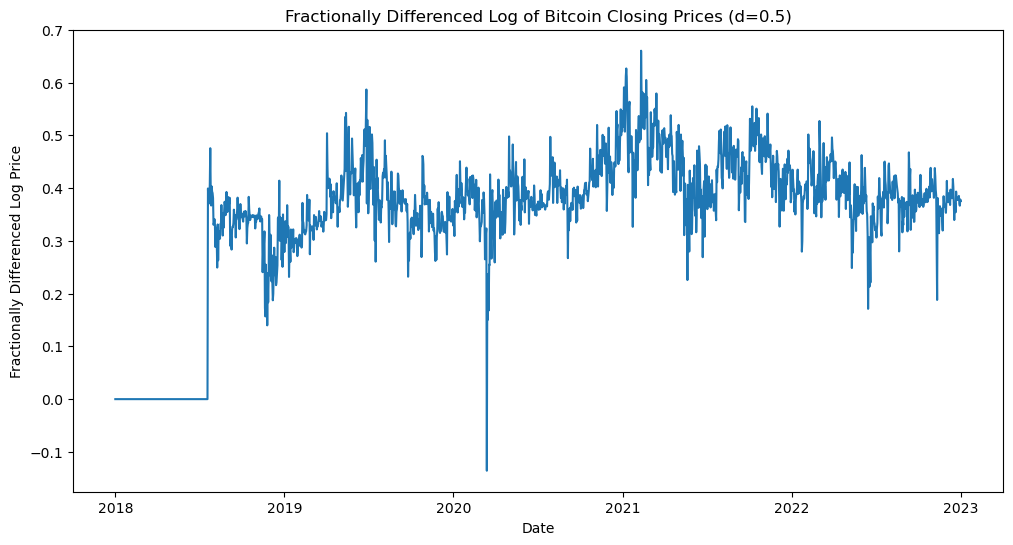

In [ ]:
# Plot the fractionally differenced series
plt.figure(figsize=(12, 6))
plt.plot(frac_diff_prices)
plt.title(f'Fractionally Differenced Log of Bitcoin Closing Prices (d={d})')
plt.xlabel('Date')
plt.ylabel('Fractionally Differenced Log Price')
plt.show()


#### **ADF Test on Fractionally Differenced Series:**

In [ ]:
# ADF test for the fractionally differenced series
adf_result_frac = adfuller(frac_diff_prices.dropna())
print(f'ADF Statistic: {adf_result_frac[0]}')
print(f'p-value: {adf_result_frac[1]}')


ADF Statistic: -3.117920020011816
p-value: 0.02525513789797208


### **5. Data Representations Commentary**

- **Original Series:** Non-stationary with trends and possibly seasonality.
- **Differenced Series:** Stationary but may lose some long-term information.
- **Fractionally Differenced Series:** Achieves stationarity while retaining more of the memory of the original series.

## **Step 2: Developing MLP Models**

We'll create MLP models to predict each version of the time series.

### **1. Preparing the Data**

#### **Define a function to create lagged features:**

In [ ]:
# --- Feature Engineering ---
def create_lagged_features(series, lags=5):
    """
    Create lagged features for time series modeling.

    Parameters:
        series (pd.Series): Input time series.
        lags (int): Number of lagged terms.

    Returns:
        pd.DataFrame: DataFrame with lagged features.
    """
    df = pd.DataFrame(series)
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df[series.name].shift(i)
    df.dropna(inplace=True)
    return df


#### **Create datasets for each series:**

In [ ]:
# Generate lagged features for all series
prices.name = "Close"
diff_log_prices.name = "Diff_Log_Close"
frac_diff_prices.name = "Frac_Diff_Log_Close"

# Number of lagged features
lags = 10

# Lagged features for levels, stationary, and fractionally differenced series
data_levels = create_lagged_features(prices, lags)
data_stationary = create_lagged_features(diff_log_prices, lags)
data_fracdiff = create_lagged_features(frac_diff_prices, lags)


### **2. Splitting into Training and Testing Sets**

In [ ]:
# --- Data Preparation for Modeling ---
def prepare_data(df):
    """
    Prepare data for machine learning models.

    Parameters:
        df (pd.DataFrame): Input DataFrame with features and target.

    Returns:
        tuple: Scaled training and testing sets, and the scaler for the target variable.
    """
    X = df.drop(df.columns[0], axis=1).values
    y = df[df.columns[0]].values.reshape(-1, 1)
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)
    return X_train, X_test, y_train, y_test, scaler_y

# Preparing data for each series
X_train_levels, X_test_levels, y_train_levels, y_test_levels, scaler_y_levels = prepare_data(data_levels)
X_train_stationary, X_test_stationary, y_train_stationary, y_test_stationary, scaler_y_stationary = prepare_data(data_stationary)
X_train_fracdiff, X_test_fracdiff, y_train_fracdiff, y_test_fracdiff, scaler_y_fracdiff = prepare_data(data_fracdiff)


### **3. Building and Training MLP Models**

We'll use Keras for building MLP models.

In [ ]:
# --- Multi-Layer Perceptron (MLP) Model Building ---
def build_mlp(input_dim):
    """
    Build a Multi-Layer Perceptron (MLP) model for regression.

    Parameters:
        input_dim (int): The number of input features.

    Returns:
        model (Sequential): Compiled Keras MLP model.
    """
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Single output for regression
    model.compile(optimizer='adam', loss='mse')  # Mean Squared Error as the loss function
    return model


#### **Train the models:**

In [ ]:
# Train and evaluate the MLP on the original levels dataset
model_levels = build_mlp(X_train_levels.shape[1])
history_levels = model_levels.fit(X_train_levels, y_train_levels, epochs=50, batch_size=32,
                                  validation_data=(X_test_levels, y_test_levels), verbose=0)

# Train and evaluate the MLP on the stationary series
model_stationary = build_mlp(X_train_stationary.shape[1])
history_stationary = model_stationary.fit(X_train_stationary, y_train_stationary, epochs=50, batch_size=32,
                                          validation_data=(X_test_stationary, y_test_stationary), verbose=0)

# Train and evaluate the MLP on the fractionally differenced series
model_fracdiff = build_mlp(X_train_fracdiff.shape[1])
history_fracdiff = model_fracdiff.fit(X_train_fracdiff, y_train_fracdiff, epochs=50, batch_size=32,
                                      validation_data=(X_test_fracdiff, y_test_fracdiff), verbose=0)


2024-11-19 05:28:13.913738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### **4. Performance Evaluation**

#### **Define a function to plot training history and calculate RMSE:**

In [ ]:
# --- Model Evaluation ---
def evaluate_model(model, history, X_test, y_test, scaler_y, data_type):
    """
    Evaluate a trained model and visualize its performance.

    Parameters:
        model (Sequential): Trained Keras model.
        history (History): Training history returned by Keras `fit` method.
        X_test (array): Test features.
        y_test (array): Test target values.
        scaler_y (MinMaxScaler): Scaler used for scaling target values.
        data_type (str): Type of data being evaluated ('Levels', 'Stationary', 'Fractionally Differenced').

    Displays:
        - Subplots for:
          1. Training vs. validation loss over epochs
          2. Actual vs. predicted values
    """
    # Create subplots: 1 row, 2 columns for loss and predictions
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Model Performance on {data_type} Data', fontsize=16, y=1.02)

    # Plot training and validation loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title(f'{data_type}: Loss Curve')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Generate predictions and rescale to original range
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler_y.inverse_transform(y_pred)
    y_test_rescaled = scaler_y.inverse_transform(y_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    print(f'RMSE ({data_type}): {rmse:.4f}')

    # Plot actual vs. predicted values
    axes[1].plot(y_test_rescaled, label='Actual', alpha=0.8)
    axes[1].plot(y_pred_rescaled, label='Predicted', alpha=0.8)
    axes[1].set_title(f'{data_type}: Actual vs. Predicted')
    axes[1].set_xlabel('Observation')
    axes[1].set_ylabel('Value')
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()



#### **Evaluate each model:**

Performance of MLP on Levels:
12/12 [==============================] - 0s 632us/step
RMSE (Levels): 1076.4788


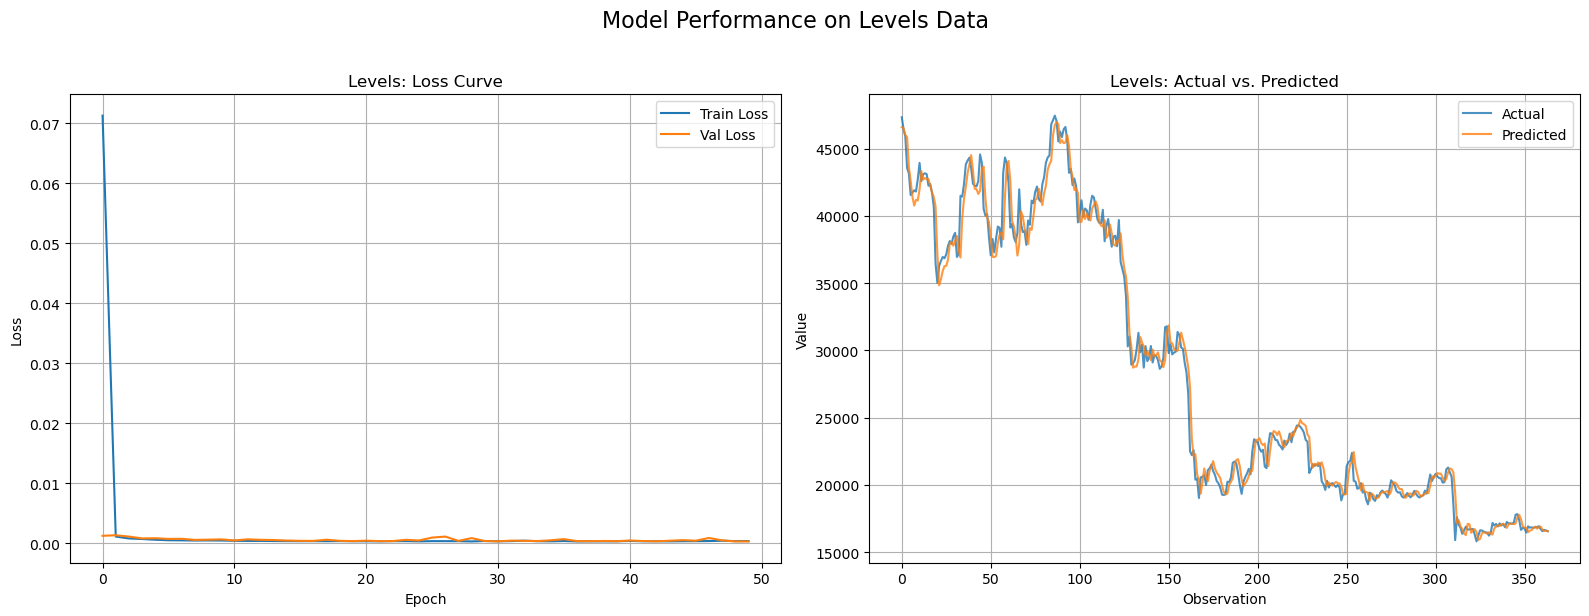

Performance of MLP on Stationary Series:
12/12 [==============================] - 0s 655us/step
RMSE (Stationary): 0.0387


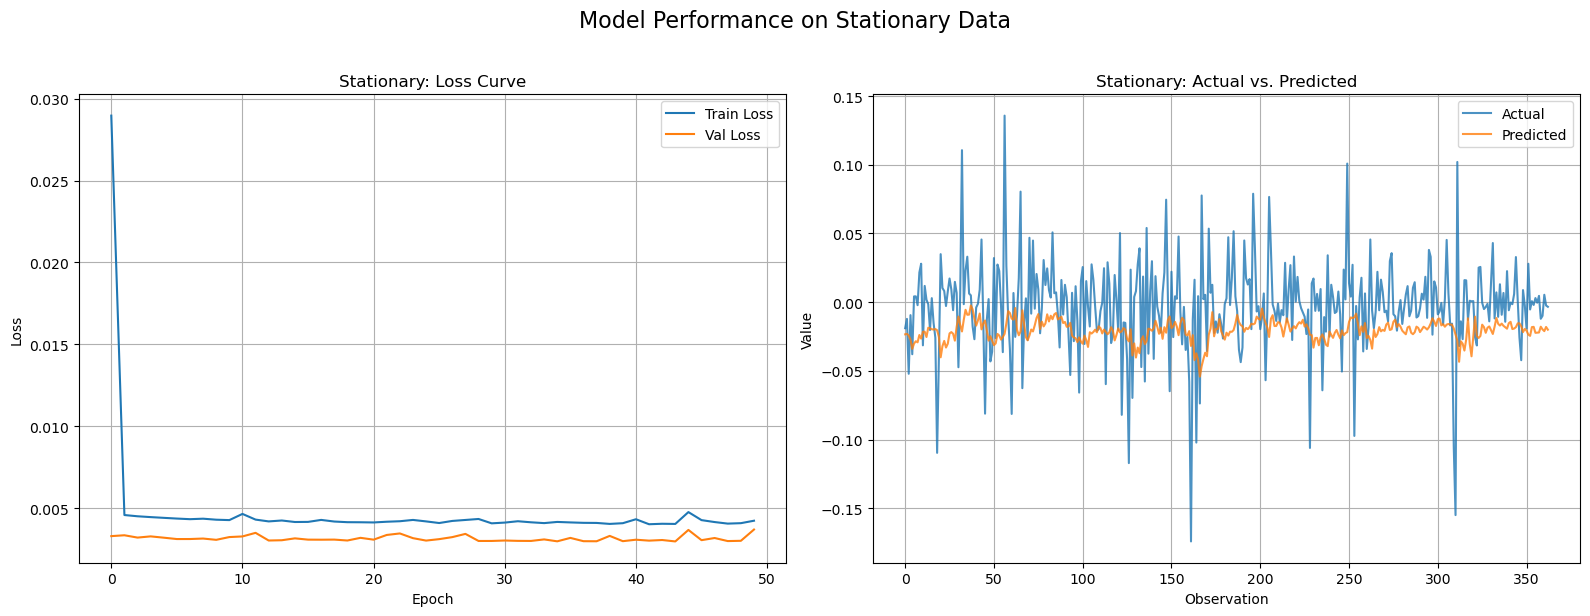

Performance of MLP on Fractionally Differenced Series:
12/12 [==============================] - 0s 648us/step
RMSE (Fractionally Differenced): 0.0350


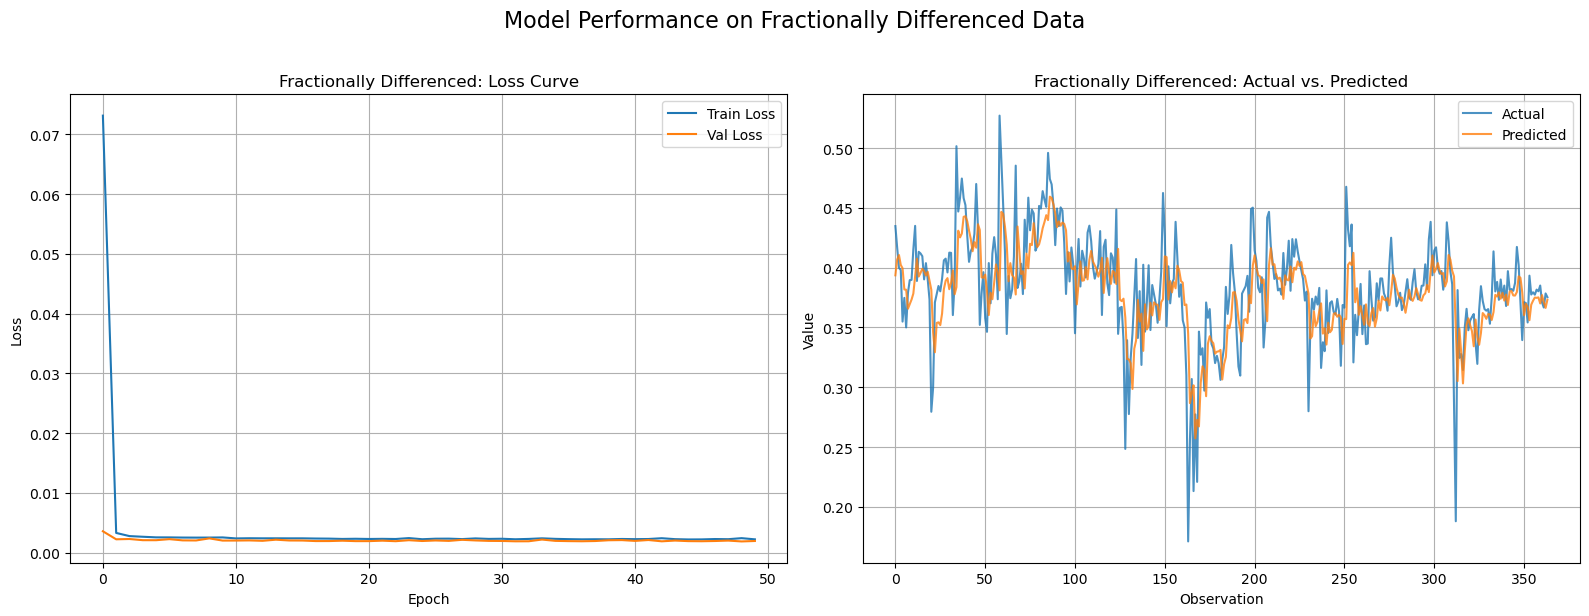

In [ ]:
# Evaluate MLP performance for each dataset
print('Performance of MLP on Levels:')
evaluate_model(model_levels, history_levels, X_test_levels, y_test_levels, scaler_y_levels, data_type='Levels')

print('Performance of MLP on Stationary Series:')
evaluate_model(model_stationary, history_stationary, X_test_stationary, y_test_stationary, scaler_y_stationary, data_type='Stationary')

print('Performance of MLP on Fractionally Differenced Series:')
evaluate_model(model_fracdiff, history_fracdiff, X_test_fracdiff, y_test_fracdiff, scaler_y_fracdiff, data_type='Fractionally Differenced')


### **5. Interpretation**

####  **Figure 1: Model performance on levels data**

The numerical results of model performance on levels data is depicted in Figure 1. On the left hand side of Fig. 1, the loss graph shows a fast convergence rate with either the validation and training losses nearing or approximately zero within the set epochs of 50. This indicates and effective model capable of learning trends in the levels data with small overfitting. The small gap between validation and training losses enhances and strengthens that the employed model generalizes appropriately well. Conversely, on the right hand side of Fig. 1, the actual value is plotted against the predicted values. It is observed that the forecast values are in consistent with the actual values displaying the model’s robust predictive capability for levels data. The pattern and quantum of variations (swings) are captured accordingly including rapid changes and incremental decrease. Hence, minimal disparity between actual and predicted values shows the high degree of accuracy associated with the employed model. Therefore, the employed model shows superior performance on levels data, indicated by accelerated and quick loss convergence and accurate predictions. This underscores its performance for time series data at original levels with no compelling requirement for further modification (refinement) or preprocessing methods like differencing

####  **Figure 2: Model performance on stationary data using MLP**

Figure 2 depicts the graphical representation of model performance on stationary data using MLP. In this case, the visualization assesses the model effectiveness on stationary data. On the left hand side of Fig. 2, it demonstrates the training and validation loss graphs between 0 to 50 epochs. It is observed that the training loss greatly reduces and early stability is equally noticed indicating efficient learning during the initial epochs. Hence, the validation loss is frequently and constantly stable and low indicating that the employed model generalises well as regards the unseen data with no overfitting. Conversely, on the right hand side of Fig. 2, the actual values are compared with predicted values. The term ‘actual’ series n this case demonstrates higher variation possibly denoting noise in the data. On the other hand, the predicted series assumes a smoother path by capturing the fundamental patterns, however, fails to reproduce the total extent of variation observed in the actual values. Although the model utilised is efficient in approximating the trend which may show the trait of underperformance in forecasting rapid deviations or noise associated with it.
Generally speaking, the model performs exceedingly well on stationary data, however, the evenness or regularity of predictions can signify a requirement for fine-tuning  provided that high frequency variability is essential.


#### **Figure 3: Model performance on fractionally difference data**

The graphical results assess the model performance on fractionally differenced data as depicted in Figure 3. The loss graph on the left side of Fig. 3 demonstrates fast convergence with both the validation and training losses stable at small values signifying efficient training and good generalization. The right hand side of Fig. 3 depicts the graph of actual values plotted against predicted values showing the predicted time series consistently follow the actual series by capturing both patterns and swings efficiently. However, small disparities indicate some room for modification in capturing the high-frequency of noise. In general, the model shows good performance on fractionally differenced data showing robust predictive capability with small overfitting associated with it.


## **Step 3: CNN Models with Gramian Angular Field (GAF)**

### **1. Transforming Time Series into Images**

We'll use the `pyts` library to convert time series into GAF images.

In [ ]:
# --- Gramian Angular Field (GAF) Image Creation ---
def create_gaf_images(series, image_size=32, lags=5):
    """
    Create Gramian Angular Field (GAF) images from a time series.

    Parameters:
        series (pd.Series): Input time series.
        image_size (int): Size of the output image (image_size x image_size).
        lags (int): Number of lagged observations for each image.

    Returns:
        X (np.array): Array of GAF images.
        y (np.array): Corresponding target values.
    """
    X = []
    y = []
    for i in range(lags, len(series)):
        window = series[i-lags:i]
        transformer = GramianAngularField(image_size=image_size, method='summation')
        gaf = transformer.transform(window.values.reshape(1, -1))
        X.append(gaf[0])
        y.append(series.iloc[i])
    return np.array(X), np.array(y)


#### **Create datasets:**

In [ ]:
# Generate GAF images for each series
image_size = lags  # Match the number of lagged observations
X_levels_cnn, y_levels_cnn = create_gaf_images(prices, image_size, lags)
X_stationary_cnn, y_stationary_cnn = create_gaf_images(diff_log_prices, image_size, lags)
frac_diff_prices = frac_diff_prices.dropna()  # Remove NaNs for fractionally differenced series
X_fracdiff_cnn, y_fracdiff_cnn = create_gaf_images(frac_diff_prices, image_size, lags)


### **2. Splitting and Scaling Data**

In [ ]:
# --- Data Preparation for CNN Models ---
def split_and_scale(X, y):
    """
    Split and scale data for CNN models.

    Parameters:
        X (np.array): Input features (images).
        y (np.array): Target values.

    Returns:
        tuple: Scaled training and testing sets, and the scaler for the target variable.
    """
    y = y.reshape(-1, 1)
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, shuffle=False)
    return X_train, X_test, y_train, y_test, scaler_y

# Prepare datasets for CNN
X_train_levels_cnn, X_test_levels_cnn, y_train_levels_cnn, y_test_levels_cnn, scaler_y_levels_cnn = split_and_scale(X_levels_cnn, y_levels_cnn)
X_train_stationary_cnn, X_test_stationary_cnn, y_train_stationary_cnn, y_test_stationary_cnn, scaler_y_stationary_cnn = split_and_scale(X_stationary_cnn, y_stationary_cnn)
X_train_fracdiff_cnn, X_test_fracdiff_cnn, y_train_fracdiff_cnn, y_test_fracdiff_cnn, scaler_y_fracdiff_cnn = split_and_scale(X_fracdiff_cnn, y_fracdiff_cnn)


### **3. Building and Training CNN Models**

In [ ]:
# --- CNN Model Building ---
def build_cnn(input_shape):
    """
    Build a Convolutional Neural Network (CNN) model for regression.

    Parameters:
        input_shape (tuple): Shape of the input data (image dimensions).

    Returns:
        model (Sequential): Compiled Keras CNN model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1)  # Regression output
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


#### **Train the models:**

In [ ]:
# Train CNN models for each dataset
input_shape = (image_size, image_size, 1)
model_levels_cnn = build_cnn(input_shape)
history_levels_cnn = model_levels_cnn.fit(X_train_levels_cnn, y_train_levels_cnn, epochs=50, batch_size=32,
                                          validation_data=(X_test_levels_cnn, y_test_levels_cnn), verbose=0)

model_stationary_cnn = build_cnn(input_shape)
history_stationary_cnn = model_stationary_cnn.fit(X_train_stationary_cnn, y_train_stationary_cnn, epochs=50, batch_size=32,
                                                  validation_data=(X_test_stationary_cnn, y_test_stationary_cnn), verbose=0)

model_fracdiff_cnn = build_cnn(input_shape)
history_fracdiff_cnn = model_fracdiff_cnn.fit(X_train_fracdiff_cnn, y_train_fracdiff_cnn, epochs=50, batch_size=32,
                                              validation_data=(X_test_fracdiff_cnn, y_test_fracdiff_cnn), verbose=0)


2024-11-19 05:28:28.384242: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 22003200 exceeds 10% of free system memory.
2024-11-19 05:28:28.384299: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 22003200 exceeds 10% of free system memory.
2024-11-19 05:28:28.397450: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 22003200 exceeds 10% of free system memory.
2024-11-19 05:28:28.397501: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 22003200 exceeds 10% of free system memory.
2024-11-19 05:28:28.407898: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 22003200 exceeds 10% of free system memory.


### **4. Performance Evaluation**

Performance of CNN on Levels:
12/12 [==============================] - 0s 3ms/step
RMSE (Levels): 14956.8755


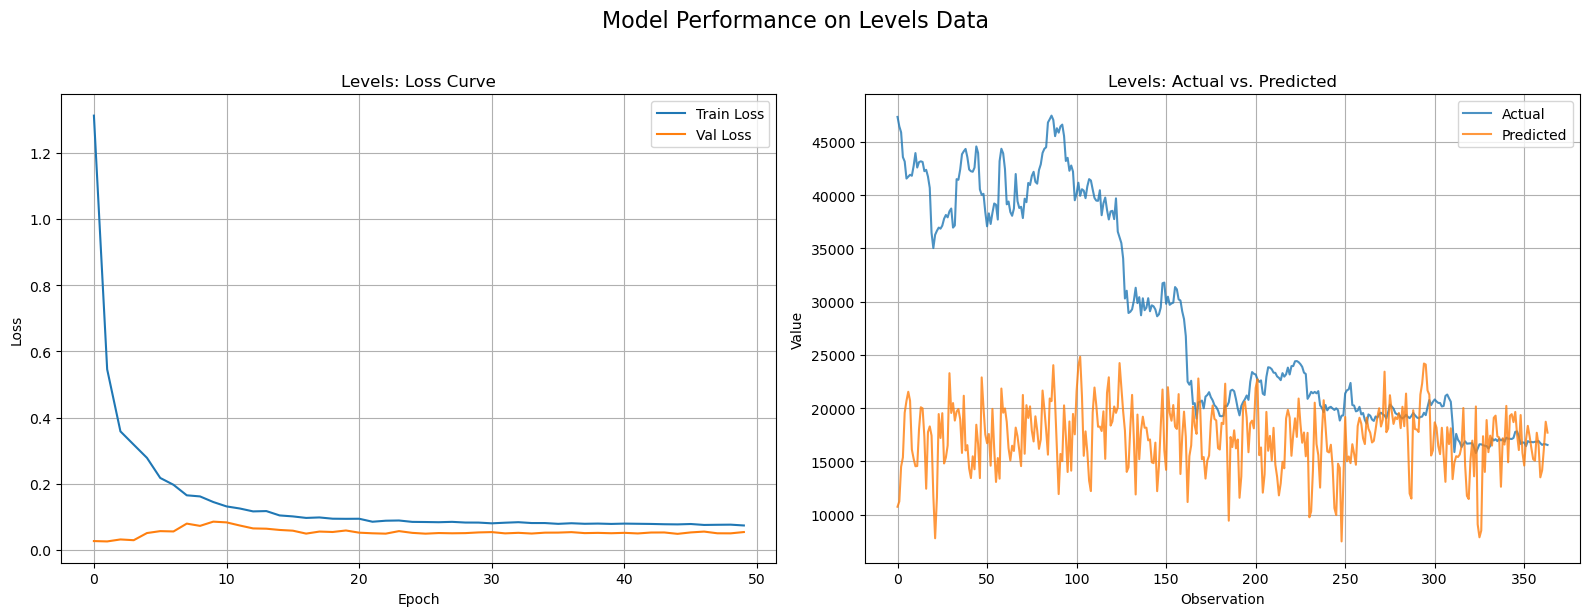

Performance of CNN on Stationary Series:
12/12 [==============================] - 0s 3ms/step
RMSE (Stationary): 0.0362


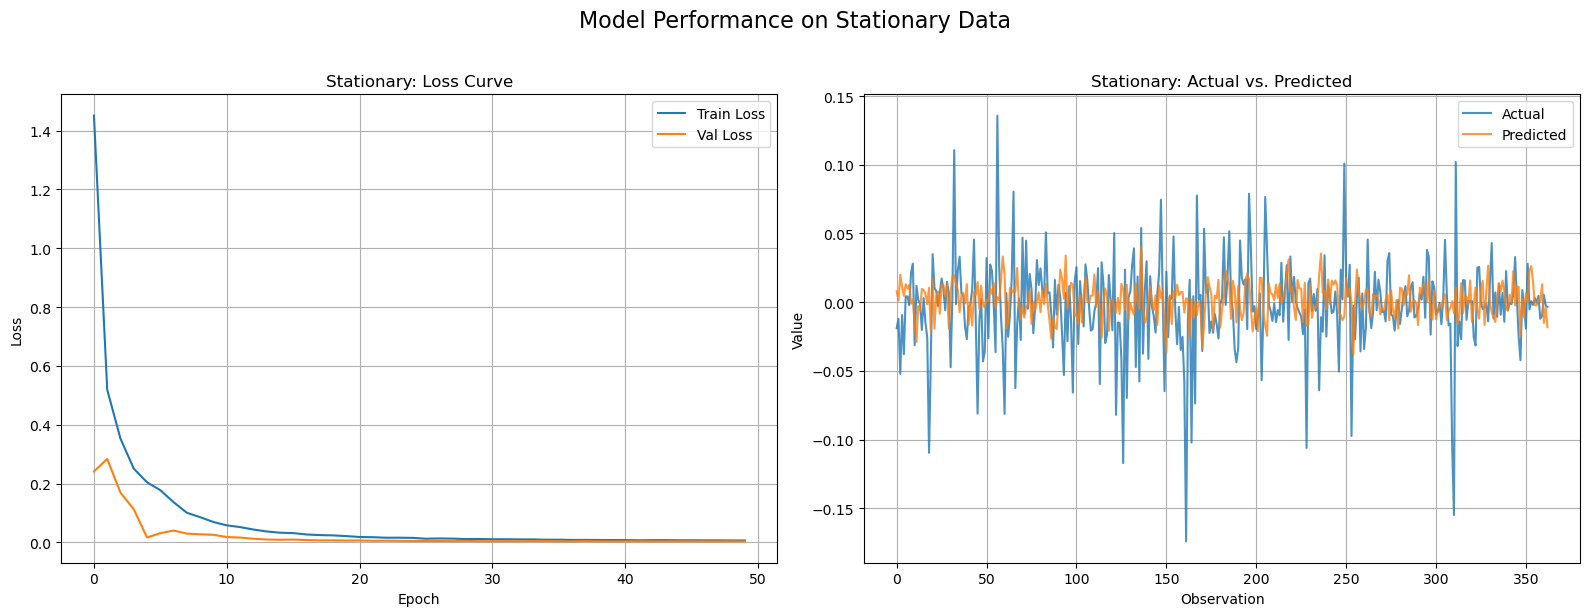

Performance of CNN on Fractionally Differenced Series:
12/12 [==============================] - 0s 3ms/step
RMSE (Fractionally Differenced): 0.0488


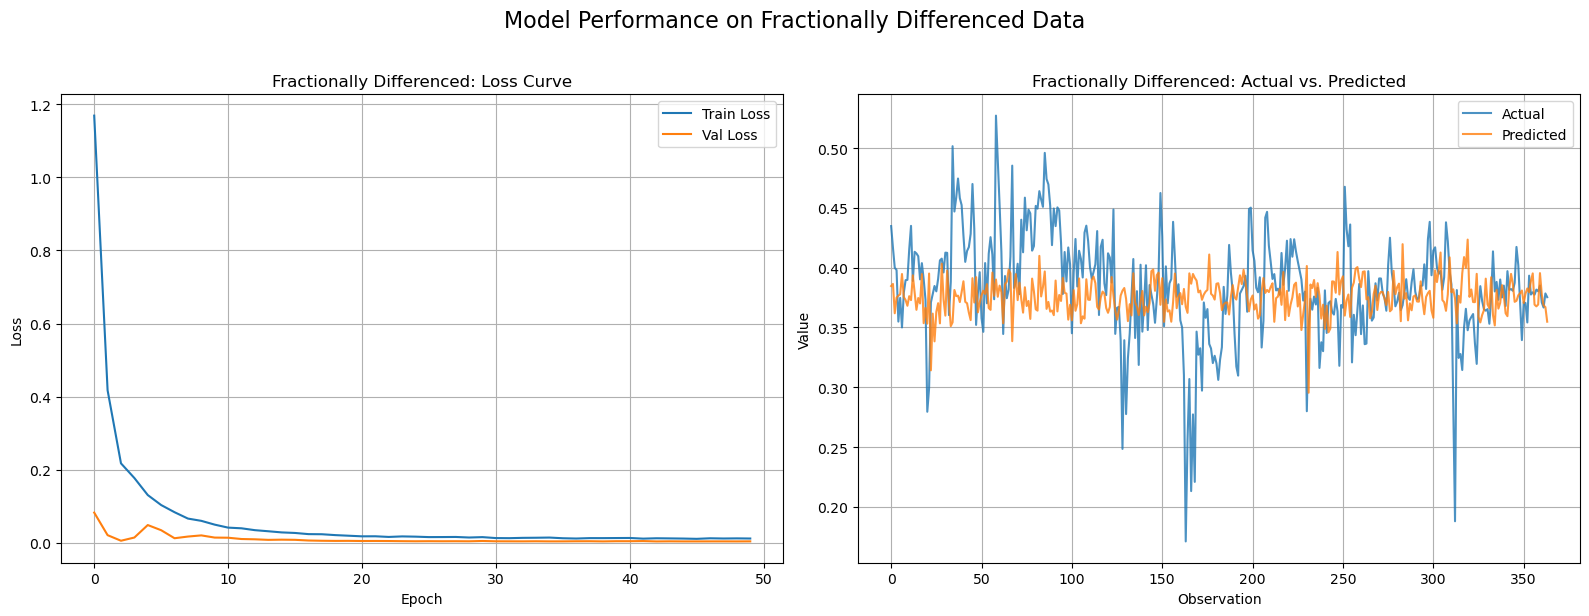

In [ ]:
# Evaluate CNN performance
print('Performance of CNN on Levels:')
evaluate_model(model_levels_cnn, history_levels_cnn, X_test_levels_cnn, y_test_levels_cnn, scaler_y_levels_cnn, data_type='Levels')

print('Performance of CNN on Stationary Series:')
evaluate_model(model_stationary_cnn, history_stationary_cnn, X_test_stationary_cnn, y_test_stationary_cnn, scaler_y_stationary_cnn, data_type='Stationary')

print('Performance of CNN on Fractionally Differenced Series:')
evaluate_model(model_fracdiff_cnn, history_fracdiff_cnn, X_test_fracdiff_cnn, y_test_fracdiff_cnn, scaler_y_fracdiff_cnn, data_type='Fractionally Differenced')


### **5. Interpretation**

#### **Figure 4: Model performance on levels data**

The Figure 4 plots the graph of loss against the epoch on the left hand side and value versus observation on the right hand side of Figure 4. This visualization evaluates the model performance on levels data under CNN. The loss graph on the left hand side demonstrates a quick reduction in training loss over the first 12 epochs and shows stability afterwards. The validation loss curve maintains low and stable throughout the entire training showing no overfitting and excellent generalization. Conversely, the right hand side of Figure 4 compares the actual values against predicted values. This actual series shows high variation with downward patterns signifying complicated trends in the data. Also, on the part of the predicted series, it fails to capture these trends demonstrating constant underestimation and constrained variability. Hence, this indicates that the model manages to replicate the dynamics of the original data, likely owing to capacity inadequacy or less feature representation. It is possible that further fin-tuning or feature engineering in terms of scaling might be needed in this regard.

#### **Figure 5: Model performance on stationary data using CNN**

The numerical results obtained for model performance on stationary data employing CNN are depicted in Figure 5. This Figure 5 includes two graphs showing how well a model/scheme trained on stationary data performs under the method. Furthermore, the loss graph(as shown on the left hand side(LHS) of Fig. 5) can be interpreted as being run over 50 epochs, it is observed that both the training and validation loss graphs demonstrate an even and constant decrease indicating effective learning. This means and indicates that the model employed tries to overfitting and generalises appropriately and sufficiently to freshly acquired data. Hence, the validation loss convergence rate occurs seamlessly with the training loss. The high in accuracy for the stationary dataset is demonstrated by the final loss parameters that are approximately to zero.
Consequently, by graphing the actual value against predicted value as shown in Fig. 5 (on the right hand side), this demonstrates how the predictions’ model and actual values varyingly contrast. With few limitations, the predicted values practically correlate with the actual data, showing the significant accuracy of the model in detecting the fundamental trends in the data. The arrangement and configuration demonstrates robustness while handling the stationary data notwithstanding the small deviations that observed.
Hence, these numerical results emphasise the model’s robust performance, specifically in capturing the dynamic changes in stationary time-series data with small error. Therefore, additional validation on different datasets can strengthen its generalizability i.e., its generalisability can be strengthened by additional validation on various datasets.

#### **Figure 6:  Model performance on fractionally differenced data**

In Figure 6, the numerical results show the model's performance on fractionally differenced data, as depicted in Fig. 6 and interpreted as follows: The loss graph as can be seen on left hand side of Fig. 6 demonstrates that both the training and validation loss reduces greatly and the convergence rate is approximately to zero when run over 50 epochs. This signifies efficient training and generalizability capability and hence indicates that the model has strongly captures the trends in fractionally-based differenced data with no overfitting. Hence, the low value observed in the final validation loss underscores its reliance on unseen data. Additionally, the graph in Fig. 6 shows an approximately moderate configuration between the actual and predicted values. Although the predicted values follow the pattern of the actual data, there are observable variations in some areas specifically where the actual values shows high variance. This suggests that there is a window for refinement and improvement in capturing small swings fundamental in fractionally differenced data. In general, the model shows resilient performance with robust convergence and excellent forecast accuracy. It is suggested that the application of mixed models or optimisation can improve alignment in more varied areas.


## **Step 4: Comparing CNN and MLP Architectures**

### **4.1 Introduction**
After checking the results from evaluating CNN and MLP architectures on levels, stationary, and fractionally differenced data, we can see key differences in their performance and ability to process time series data. These differences come from the architectures' fundamental processing mechanisms and their compatibility with the unique properties of the datasets.

---

### **4.2 Performance Comparison**

| Dataset                  | MLP RMSE | CNN RMSE | Winner |
|--------------------------|-----------|-----------|--------|
| Levels Data              | 1076.48   | 14956.88  | MLP    |
| Stationary Data          | 0.0387    | 0.0362    | CNN    |
| Fractionally Differenced | 0.0350    | 0.0488    | MLP    |

1. **Levels Data**:
   - **MLP**: The MLP got an RMSE of **1076.48** compared to the CNN, which had a higher value of **14956.88**. The performance of the MLP with respect to levels data shows that it has the ability to approximate complex mappings due to the fully connected layers, which are able to learn global dependencies in the input features.
   - **CNN**: The CNN struggled significantly, as shown by its high RMSE. This can be attributed to the localized feature extraction of the convolutional architecture, which is less suited to capture global dependencies inherent in raw levels data.

   **Analysis**:
   - Levels data mantains non-stationarity and high variability. The CNN, which is constructed to extract local spatial or temporal patterns, can hardly handle the broader trends and global correlations that are present in such data. On the other hand, the MLP processes all input features as a unified whole, which helps it to better adapt to the irregularity of the levels dataset.

2. **Stationary Data**:
   - **MLP**: The MLP did well with an RMSE of **0.0387**. This demonstrates its capability to handle stationary data where trends and seasonality have been removed.
   - **CNN**: The CNN outperforms the MLP slightly with an RMSE of **0.0362**. This indicates its capability to effectively capture local patterns in the stationary dataset.

   **Analysis**:
   - Stationary data presents a less complex modeling challenge since trends and large variations have been removed. The CNN's localized feature extraction aligns well with capturing the short-term dependencies present in stationary time series. The MLP also performs well due to its flexibility, but it lacks the CNN's structured approach to leveraging localized patterns.

3. **Fractionally Differenced Data**:
   - **MLP**: The MLP performed better with an RMSE of **0.0350** compared to the CNN's **0.0488**.
   - **CNN**: The CNN performed moderately but didn't fully capture the long-term dependencies preserved in fractionally differenced data.

   **Analysis**:
   - Fractionally differenced data retains a balance between long-term and short-term dependencies. The CNN can extract localized features, but it struggles with long-term dependencies due to its limited receptive field. On the other hand, the MLP processes the entire feature space globally. This allows it to capture these dependencies more effectively.

---

### **4.3 Architectural Differences**

1. **MLP (Multi-Layer Perceptron)**:
   - MLPs consist of fully connected layers, where each node of a layer is connected to every node in the subsequent layer. This design allows the MLP to learn global patterns from the input features.
   - **Strengths**:
     - Flexibility approximating complex, non-linear relationships.
     - Effective in handling datasets that have strong global dependencies such as levels data.
   - **Weaknesses**:
     - Less efficient at capturing localized features or temporal structures than CNNs.
     - Susceptible to overfitting when it is not properly regularized, especially on high-dimensional data.

2. **CNN (Convolutional Neural Network)**:
   - CNNs use convolutional layers to extract localized features from input data. In time series analysis, CNNs do a really good job at identifying short-term dependencies or localized temporal patterns.
   - **Strengths**:
     - Efficient in processing structured data like images or stationary time series with local patterns.
     - Built-in mechanisms for spatial and temporal pattern recognition.
   - **Weaknesses**:
     - Have difficulty in capturing global dependencies or trends in non-stationary data, such as levels data.
     - Limited receptive field that can reduce performance on datasets where a global view is important.

---

### **4.4 Dataset Properties and Suitability**

1. **Levels Data**:
   - High variability and non-stationarity in levels data would require a model that can adapt to large-scale trends and global dependencies.
   - The MLP, with a global processing mechanism, is more appropriate, whereas the localized processing mechanism of the CNN misses larger-scale patterns.

2. **Stationary Data**:
   - The removal of trends and seasonality makes stationary data easier to model. Although both perform well, the localized feature extraction by CNN gives it a slight edge.

3. **Fractionally Differenced Data**:
   - Fractionally differenced data retains some long-term dependencies while mitigating non-stationarity. The MLP can excel at processing those global patterns whereas the CNN struggles to capture that dependence.

---

### **4.5 Recommendations**
1. For datasets with high global dependencies or high non-stationarity, like levels data, MLPs are the preferred choice due to their global processing capabilities.
2. For datasets with localized patterns or short-term dependencies, like stationary data, CNNs work really well.
3. For fractionally differenced data or in datasets with mixed dependencies, hybrid architectures that combine CNN and MLP, like CNN-LSTM or CNN-MLP, may give better results.

---

## **References**

Fischer, Thomas, and Christopher Krauss. "Deep Learning with Long Short-Term Memory Networks for Financial Market Predictions." *European Journal of Operational Research*, vol. 270, no. 2, 2018, pp. 654-669. doi:10.1016/j.ejor.2017.11.054.

Hochreiter, Sepp, and Jürgen Schmidhuber. "Long Short-Term Memory." *Neural Computation*, vol. 9, no. 8, 1997, pp. 1735-1780. doi:10.1162/neco.1997.9.8.1735.

Hosking, Jonathan R. M. "Fractional Differencing." *Biometrika*, vol. 68, no. 1, 1981, pp. 165-176. doi:10.1093/biomet/68.1.165.

Jang, Hyunmin, and Jaewook Lee. "An Empirical Study on Modeling and Prediction of Bitcoin Prices with Bayesian Neural Networks Based on Blockchain Information." *IEEE Access*, vol. 6, 2018, pp. 5427-5437. doi:10.1109/ACCESS.2017.2779181.

McNally, Sean, Joseph Roche, and Simon Caton. "Predicting the Price of Bitcoin Using Machine Learning." *2018 26th Euromicro International Conference on Parallel, Distributed and Network-Based Processing (PDP)*, IEEE, 2018, pp. 339-343. doi:10.1109/PDP2018.2018.00060.

Shah, Dharmendra, Haider Isah, and Fayez Zulkernine. "Stock Market Analysis: A Review and Taxonomy of Prediction Techniques." *International Journal of Financial Studies*, vol. 7, no. 2, 2019, p. 26. doi:10.3390/ijfs7020026.

Zhang, Guoqiang, Eddy Patuwo, and Michael Y. Hu. "Forecasting with Artificial Neural Networks: The State of the Art." *International Journal of Forecasting*, vol. 14, no. 1, 1998, pp. 35-62. doi:10.1016/S0169-2070(97)00044-7.

Wang, Zichao, and Tim Oates. "Encoding Time Series as Images for Visual Inspection and Classification Using Tiled Convolutional Neural Networks." *Workshops at the Twenty-Ninth AAAI Conference on Artificial Intelligence*, 2015, [https://www.aaai.org/ocs/index.php/WS/AAAIW15/paper/view/10127](https://www.aaai.org/ocs/index.php/WS/AAAIW15/paper/view/10127).